<a href="https://colab.research.google.com/github/luciainnocenti/Homework2-Caltech101/blob/master/MLDL_Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Install requirements**

In [0]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

# **Import libraries**

In [0]:
import os
import logging
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np


# **Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

## Adjusted Hyperparameters

In [0]:
LR = 0.01            # Good enought parameter with NUM_EPOCHS = 30

In [0]:
LR = 1e-3           

NUM_EPOCHS = 100

In [0]:
LR = 0.01

NUM_EPOCHS = 40

# **Define Data Preprocessing**

In the official documentation of pretrained models on torchvision there is the following piece of code:

    for model_name in __all__: 
        means[model_name] = [0.485, 0.456, 0.406]
        stds[model_name] = [0.229, 0.224, 0.225]

So I set the *transorms.Normalize* mean and standard deviation as defined here

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #ImageNet Mean and SD
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #ImageNet Mean and SD                                 
])

Data Augmentation:

In [0]:
list_degrees = [10,30]

In [0]:
train_transform = transforms.Compose([#transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=list_degrees),
                                      transforms.ColorJitter(),
                                      #transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(224),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])  # Imagenet standards
                                  ])

# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #ImageNet Mean and SD                                 
])

# **Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/luciainnocenti/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes , val_indexes = train_dataset.__getSubsets__(50)

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9301, done.
remote: Total 9301 (delta 0), reused 0 (delta 0), pack-reused 9301
Receiving objects: 100% (9301/9301), 129.49 MiB | 12.73 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Checking out files: 100% (9149/9149), done.
Train Dataset: 3045
Valid Dataset: 3093
Test Dataset: 2893


# **Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# **Prepare Network**

## Non pretrained Network

In [0]:
net = alexnet() # Loading AlexNet model

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d


## Pretrained Network

To improve performance, use a pretrained Model.
Let's see how AlexNet is defined:

In [0]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)
alexNet

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Train last Layer

Now we use AlexNet and we modify only the last layer, that will be trained by the train section:

In [0]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

#Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

#Modify the last layer. It will be trained
alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

### Train FC layers

Use a pretrained AlexNet by un-freezing all the Fully Connetted Layers

In [0]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

#Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

#Unfreeze all the FC layers:
alexNet.classifier[4] = nn.Linear(4096, 4096)
alexNet.classifier[5] = nn.ReLU(inplace=True)
alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)



# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

### Train not-FC layers

Use a pretrained AlexNet by un-freezing all the non-Fully Connetted Layers

In [0]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

#Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

#Unfreeze all the nonFC layers:
alexNet.classifier[0] = nn.Dropout(p=0.5, inplace=False)
alexNet.classifier[1] = nn.Linear(9216, 4096)
alexNet.classifier[2] = nn.ReLU(inplace=True)
alexNet.classifier[3] = nn.Dropout(p=0.5, inplace=False)

alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

# **Prepare Training**

In [0]:
#Define Loss function and optimizator
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(alexNet.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.SGD(alexNet.parameters(), lr=LR, momentum=MOMENTUM)#Optimizer to use in case of early Stop

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

If the early Stop is selected, run the following part:

In [0]:
MAX_EPOCHS = 3
epochs_no_improve = 0
val_min_loss = sys.maxsize

# **Train**

*Early stopping halts the training when the validation loss has not decreased for a number of epochs. Each time the validation loss does decrease, the model weights are saved so we can later load in the best model. Early stopping is an effective method to prevent overfitting on the training data. If we continue training, the training loss will continue to decrease, but the validation loss will increase because the model is starting to memorize the training data. Early stopping prevents this from happening, and, if we save the model each epoch when the validation loss decreases, we are able to retrieve the model that does best on the validation data.*

In [0]:
def testOnValidation(input_dataLoader):
    alexNet.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(input_dataLoader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = alexNet(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    loss = criterion(outputs, labels)

    print('Validation Accuracy: {}'.format(accuracy))
    print('Validation Loss: {}'.format(loss))
    return (accuracy,loss)

In [0]:
# By default, everything is loaded to cpu
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime

pars = []
max_accuracy = 0
current_step = 0
epochs_no_improve = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS))#, scheduler.get_lr()))
  print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))

  alexNet.train() # Sets module in training mode

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    
    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = alexNet(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  #At each epoch, evaluate the model on the validation set:  
  returned_elements = testOnValidation(val_dataloader)
  pars.append( (scheduler.get_lr(), returned_elements[0], returned_elements[1].item(), loss) )
  if( returned_elements[0] > max_accuracy):
    max_accuracy = returned_elements[0]
    best_model = alexNet
  
  ##Implements early stop:
  #if( returned_elements[1] <= val_min_loss):
  #  epochs_no_improve = 0
  #  val_min_loss = returned_elements[1]
  #else:
  #  epochs_no_improve += 1
  #  if(epochs_no_improve == 1):
  #      best_model = alexNet
  #  if(epochs_no_improve >= MAX_EPOCHS):
  #    print("Early Stop! Number of epochs = " , epoch)
  #    
  #    break

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/40
Step 0, Loss 4.626338958740234
Step 10, Loss 4.614694595336914
Step 20, Loss 4.594464302062988
Step 30, Loss 4.542603969573975
Step 40, Loss 4.345853328704834


100%|██████████| 49/49 [00:07<00:00,  6.90it/s]

Validation Accuracy: 0.09666989977368251
Validation Loss: 5.013100624084473
Starting epoch 2/40



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 50, Loss 4.040584087371826
Step 60, Loss 3.3692097663879395
Step 70, Loss 3.32222056388855
Step 80, Loss 3.441837787628174
Step 90, Loss 3.0029006004333496


100%|██████████| 49/49 [00:06<00:00,  7.36it/s]

Validation Accuracy: 0.31652117685095377
Validation Loss: 4.685200214385986
Starting epoch 3/40


Step 100, Loss 3.148549795150757
Step 110, Loss 3.5796780586242676
Step 120, Loss 2.7340657711029053
Step 130, Loss 3.3399620056152344


  0%|          | 0/49 [00:00<?, ?it/s]

Step 140, Loss 2.978365659713745


100%|██████████| 49/49 [00:06<00:00,  7.27it/s]

Validation Accuracy: 0.38409311348205627
Validation Loss: 4.269169330596924
Starting epoch 4/40


Step 150, Loss 2.7670538425445557
Step 160, Loss 2.477644681930542
Step 170, Loss 2.573915719985962
Step 180, Loss 2.513262987136841


100%|██████████| 49/49 [00:07<00:00,  6.85it/s]

Validation Accuracy: 0.45651471063692206
Validation Loss: 2.4373440742492676
Starting epoch 5/40


Step 190, Loss 2.3347578048706055
Step 200, Loss 2.0622432231903076
Step 210, Loss 2.1834704875946045
Step 220, Loss 1.3608794212341309
Step 230, Loss 2.068441152572632


100%|██████████| 49/49 [00:07<00:00,  6.95it/s]

Validation Accuracy: 0.5948916909149693
Validation Loss: 0.5269826054573059
Starting epoch 6/40


Step 240, Loss 1.554938793182373
Step 250, Loss 1.6049658060073853
Step 260, Loss 1.3709087371826172
Step 270, Loss 1.449491024017334


  0%|          | 0/49 [00:00<?, ?it/s]

Step 280, Loss 1.0675907135009766


100%|██████████| 49/49 [00:06<00:00,  7.31it/s]

Validation Accuracy: 0.6708697057872616
Validation Loss: 0.7767989635467529
Starting epoch 7/40


Step 290, Loss 0.7430938482284546
Step 300, Loss 1.030249834060669
Step 310, Loss 1.2097973823547363
Step 320, Loss 1.0264240503311157


100%|██████████| 49/49 [00:06<00:00,  7.12it/s]

Validation Accuracy: 0.7413514387326221
Validation Loss: 1.0248100757598877
Starting epoch 8/40


Step 330, Loss 0.6842122077941895
Step 340, Loss 0.661067545413971
Step 350, Loss 0.35061874985694885
Step 360, Loss 0.9567098617553711
Step 370, Loss 0.4705735146999359


100%|██████████| 49/49 [00:06<00:00,  7.13it/s]

Validation Accuracy: 0.7432913029421274
Validation Loss: 0.5442509651184082
Starting epoch 9/40


Step 380, Loss 0.5039842128753662
Step 390, Loss 0.5910953879356384
Step 400, Loss 0.33784419298171997
Step 410, Loss 0.5751286149024963
Step 420, Loss 0.4585871398448944


100%|██████████| 49/49 [00:06<00:00,  7.43it/s]

Validation Accuracy: 0.7707727125767863
Validation Loss: 0.3959049880504608
Starting epoch 10/40


Step 430, Loss 0.23778198659420013
Step 440, Loss 0.1889268308877945
Step 450, Loss 0.19984234869480133
Step 460, Loss 0.22085554897785187


100%|██████████| 49/49 [00:06<00:00,  7.44it/s]

Validation Accuracy: 0.7795021015195603
Validation Loss: 0.07707373052835464
Starting epoch 11/40


Step 470, Loss 0.3981018662452698
Step 480, Loss 0.14276300370693207
Step 490, Loss 0.13821212947368622
Step 500, Loss 0.20006218552589417
Step 510, Loss 0.17534008622169495


100%|██████████| 49/49 [00:06<00:00,  7.54it/s]

Validation Accuracy: 0.8060135790494666
Validation Loss: 0.24685604870319366
Starting epoch 12/40


Step 520, Loss 0.18265196681022644
Step 530, Loss 0.19092652201652527
Step 540, Loss 0.1193934828042984
Step 550, Loss 0.08803360909223557
Step 560, Loss 0.16269049048423767


100%|██████████| 49/49 [00:06<00:00,  7.53it/s]

Validation Accuracy: 0.7943743937924346
Validation Loss: 0.7295634150505066
Starting epoch 13/40


Step 570, Loss 0.23169849812984467
Step 580, Loss 0.17673511803150177
Step 590, Loss 0.08136670291423798
Step 600, Loss 0.14256110787391663


  0%|          | 0/49 [00:00<?, ?it/s]

Step 610, Loss 0.13926662504673004


100%|██████████| 49/49 [00:06<00:00,  7.40it/s]

Validation Accuracy: 0.8034270934367927
Validation Loss: 0.5737301111221313
Starting epoch 14/40


Step 620, Loss 0.20138683915138245
Step 630, Loss 0.07899296283721924
Step 640, Loss 0.12446284294128418
Step 650, Loss 0.1509827822446823


100%|██████████| 49/49 [00:06<00:00,  7.49it/s]

Validation Accuracy: 0.8082767539605561
Validation Loss: 0.2126757800579071
Starting epoch 15/40


Step 660, Loss 0.06866231560707092
Step 670, Loss 0.08108361065387726
Step 680, Loss 0.05143877863883972
Step 690, Loss 0.07913835346698761
Step 700, Loss 0.09254242479801178


100%|██████████| 49/49 [00:06<00:00,  7.45it/s]

Validation Accuracy: 0.812479793081151
Validation Loss: 0.23794859647750854
Starting epoch 16/40


Step 710, Loss 0.04105420410633087
Step 720, Loss 0.10055507719516754
Step 730, Loss 0.08346475660800934
Step 740, Loss 0.0550864040851593


  0%|          | 0/49 [00:00<?, ?it/s]

Step 750, Loss 0.0261395126581192


100%|██████████| 49/49 [00:06<00:00,  7.36it/s]

Validation Accuracy: 0.8115098609763983
Validation Loss: 0.2537534832954407
Starting epoch 17/40


Step 760, Loss 0.03982017934322357
Step 770, Loss 0.043498694896698
Step 780, Loss 0.04303984344005585
Step 790, Loss 0.04952821135520935


100%|██████████| 49/49 [00:06<00:00,  7.45it/s]

Validation Accuracy: 0.8147429679922406
Validation Loss: 0.36939889192581177
Starting epoch 18/40


Step 800, Loss 0.06952401995658875
Step 810, Loss 0.09168744087219238
Step 820, Loss 0.047989606857299805
Step 830, Loss 0.09825129806995392
Step 840, Loss 0.08672970533370972


100%|██████████| 49/49 [00:06<00:00,  7.55it/s]

Validation Accuracy: 0.8215324927255092
Validation Loss: 0.3657744228839874
Starting epoch 19/40


Step 850, Loss 0.08373691141605377
Step 860, Loss 0.09383970499038696
Step 870, Loss 0.07124102115631104
Step 880, Loss 0.0985352098941803


  0%|          | 0/49 [00:00<?, ?it/s]

Step 890, Loss 0.02223639190196991


100%|██████████| 49/49 [00:06<00:00,  7.41it/s]

Validation Accuracy: 0.821209182023925
Validation Loss: 0.4782649874687195
Starting epoch 20/40


Step 900, Loss 0.023052603006362915
Step 910, Loss 0.03379856050014496
Step 920, Loss 0.09491384029388428
Step 930, Loss 0.08313459157943726


100%|██████████| 49/49 [00:06<00:00,  7.35it/s]

Validation Accuracy: 0.8166828322017459
Validation Loss: 0.3532921075820923
Starting epoch 21/40


Step 940, Loss 0.025139540433883667
Step 950, Loss 0.04664584994316101
Step 960, Loss 0.06901317834854126
Step 970, Loss 0.0851384848356247
Step 980, Loss 0.07402458786964417


100%|██████████| 49/49 [00:06<00:00,  7.41it/s]

Validation Accuracy: 0.8205625606207565
Validation Loss: 0.51640784740448
Starting epoch 22/40


Step 990, Loss 0.07127337157726288
Step 1000, Loss 0.025959134101867676
Step 1010, Loss 0.04438239336013794
Step 1020, Loss 0.031200438737869263
Step 1030, Loss 0.03083258867263794


100%|██████████| 49/49 [00:06<00:00,  7.16it/s]

Validation Accuracy: 0.8192693178144197
Validation Loss: 0.6192744970321655
Starting epoch 23/40


Step 1040, Loss 0.08658695220947266
Step 1050, Loss 0.03194291889667511
Step 1060, Loss 0.01810668408870697
Step 1070, Loss 0.029376238584518433


  0%|          | 0/49 [00:00<?, ?it/s]

Step 1080, Loss 0.04533772170543671


100%|██████████| 49/49 [00:06<00:00,  7.31it/s]

Validation Accuracy: 0.8244422890397672
Validation Loss: 0.3735288381576538
Starting epoch 24/40


Step 1090, Loss 0.06699405610561371
Step 1100, Loss 0.02285820245742798
Step 1110, Loss 0.10511790215969086
Step 1120, Loss 0.026701629161834717


100%|██████████| 49/49 [00:06<00:00,  7.07it/s]

Validation Accuracy: 0.8283220174587779
Validation Loss: 0.45139414072036743
Starting epoch 25/40


Step 1130, Loss 0.018631204962730408
Step 1140, Loss 0.08219815790653229
Step 1150, Loss 0.022073835134506226
Step 1160, Loss 0.06338199973106384
Step 1170, Loss 0.03722084313631058


100%|██████████| 49/49 [00:06<00:00,  7.23it/s]

Validation Accuracy: 0.8292919495635306
Validation Loss: 0.4974646270275116
Starting epoch 26/40


Step 1180, Loss 0.04512853920459747
Step 1190, Loss 0.0524408221244812
Step 1200, Loss 0.015025123953819275
Step 1210, Loss 0.038998037576675415
Step 1220, Loss 0.020481973886489868


100%|██████████| 49/49 [00:06<00:00,  7.33it/s]

Validation Accuracy: 0.8231490462334303
Validation Loss: 0.29355213046073914
Starting epoch 27/40


Step 1230, Loss 0.10926805436611176
Step 1240, Loss 0.03897362947463989
Step 1250, Loss 0.017828285694122314
Step 1260, Loss 0.03315277397632599


100%|██████████| 49/49 [00:06<00:00,  7.61it/s]

Validation Accuracy: 0.8254122211445198
Validation Loss: 0.4144192337989807
Starting epoch 28/40


Step 1270, Loss 0.07105050981044769
Step 1280, Loss 0.04908311367034912
Step 1290, Loss 0.015588849782943726
Step 1300, Loss 0.03108750283718109
Step 1310, Loss 0.029667824506759644


100%|██████████| 49/49 [00:06<00:00,  7.56it/s]

Validation Accuracy: 0.8309085030714517
Validation Loss: 0.5609999895095825
Starting epoch 29/40


Step 1320, Loss 0.026351705193519592
Step 1330, Loss 0.03714945912361145
Step 1340, Loss 0.05377756059169769
Step 1350, Loss 0.030481919646263123


  0%|          | 0/49 [00:00<?, ?it/s]

Step 1360, Loss 0.06819823384284973


100%|██████████| 49/49 [00:06<00:00,  7.40it/s]

Validation Accuracy: 0.8276753960556095
Validation Loss: 0.3117125928401947
Starting epoch 30/40


Step 1370, Loss 0.026390090584754944
Step 1380, Loss 0.026737257838249207
Step 1390, Loss 0.012246310710906982
Step 1400, Loss 0.07159797847270966


100%|██████████| 49/49 [00:06<00:00,  7.58it/s]

Validation Accuracy: 0.8257355318461042
Validation Loss: 0.4150238633155823
Starting epoch 31/40


Step 1410, Loss 0.02143619954586029
Step 1420, Loss 0.0211859792470932
Step 1430, Loss 0.09570391476154327
Step 1440, Loss 0.08427508175373077
Step 1450, Loss 0.03851036727428436


100%|██████████| 49/49 [00:06<00:00,  7.60it/s]

Validation Accuracy: 0.8279987067571937
Validation Loss: 0.2691223919391632
Starting epoch 32/40


Step 1460, Loss 0.03015497326850891
Step 1470, Loss 0.006970033049583435
Step 1480, Loss 0.15067733824253082
Step 1490, Loss 0.017800122499465942
Step 1500, Loss 0.018638402223587036


100%|██████████| 49/49 [00:06<00:00,  7.24it/s]

Validation Accuracy: 0.8244422890397672
Validation Loss: 0.5920277833938599
Starting epoch 33/40


Step 1510, Loss 0.02205619215965271
Step 1520, Loss 0.006713107228279114
Step 1530, Loss 0.03485521674156189
Step 1540, Loss 0.027684271335601807


  0%|          | 0/49 [00:00<?, ?it/s]

Step 1550, Loss 0.05912423133850098


100%|██████████| 49/49 [00:06<00:00,  7.22it/s]

Validation Accuracy: 0.8247655997413514
Validation Loss: 0.5824443101882935
Starting epoch 34/40


Step 1560, Loss 0.018409833312034607
Step 1570, Loss 0.09858700633049011
Step 1580, Loss 0.05196294188499451
Step 1590, Loss 0.03373946249485016


100%|██████████| 49/49 [00:06<00:00,  7.25it/s]

Validation Accuracy: 0.8334949886841254
Validation Loss: 0.45429810881614685
Starting epoch 35/40


Step 1600, Loss 0.011768773198127747
Step 1610, Loss 0.018408536911010742
Step 1620, Loss 0.016087010502815247
Step 1630, Loss 0.031198561191558838
Step 1640, Loss 0.08356095850467682


100%|██████████| 49/49 [00:06<00:00,  7.36it/s]

Validation Accuracy: 0.8383446492078888
Validation Loss: 0.3833181858062744
Starting epoch 36/40


Step 1650, Loss 0.016137734055519104
Step 1660, Loss 0.013914048671722412
Step 1670, Loss 0.10104481875896454
Step 1680, Loss 0.07105083763599396


  0%|          | 0/49 [00:00<?, ?it/s]

Step 1690, Loss 0.022460296750068665


100%|██████████| 49/49 [00:06<00:00,  7.28it/s]

Validation Accuracy: 0.8351115421920465
Validation Loss: 0.3264002501964569
Starting epoch 37/40


Step 1700, Loss 0.031492188572883606
Step 1710, Loss 0.08837853372097015
Step 1720, Loss 0.0445544570684433
Step 1730, Loss 0.057647109031677246


100%|██████████| 49/49 [00:06<00:00,  7.21it/s]

Validation Accuracy: 0.8312318137730359
Validation Loss: 0.3614542782306671
Starting epoch 38/40


Step 1740, Loss 0.048710644245147705
Step 1750, Loss 0.034794434905052185
Step 1760, Loss 0.0631900280714035
Step 1770, Loss 0.03818631172180176
Step 1780, Loss 0.012444332242012024


100%|██████████| 49/49 [00:06<00:00,  7.26it/s]

Validation Accuracy: 0.8347882314904623
Validation Loss: 0.3617298901081085
Starting epoch 39/40


Step 1790, Loss 0.0630161464214325
Step 1800, Loss 0.01339586079120636
Step 1810, Loss 0.012987479567527771
Step 1820, Loss 0.0495469868183136
Step 1830, Loss 0.031797587871551514


100%|██████████| 49/49 [00:06<00:00,  7.24it/s]

Validation Accuracy: 0.8312318137730359
Validation Loss: 0.2486364245414734
Starting epoch 40/40


Step 1840, Loss 0.018927201628684998
Step 1850, Loss 0.0342077761888504
Step 1860, Loss 0.01859327405691147
Step 1870, Loss 0.0425456166267395


100%|██████████| 49/49 [00:06<00:00,  7.64it/s]

Validation Accuracy: 0.8296152602651148
Validation Loss: 0.4260936975479126


## Plot and evaluate

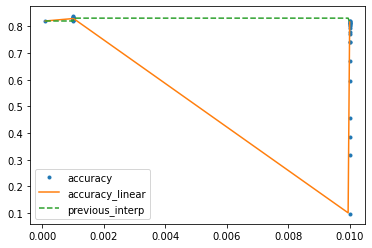

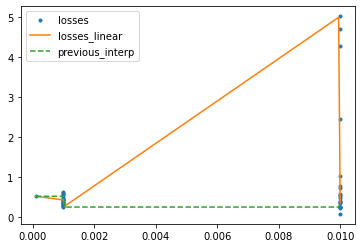

In [0]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

lrs = []
val_accs = []
val_losses = []
train_losses = []

for el in pars:
  lrs.extend(el[0])
  val_accs.append(el[1])
  val_losses.append(el[2])
  train_losses.append(el[3])
f_accs_1 = interp1d(lrs, val_accs)
f_accs_2 = interp1d(lrs, val_accs, kind='previous')

f_losses_1 = interp1d(lrs, val_losses)
f_losses_2 = interp1d(lrs, val_losses, kind='previous')

xnew = np.linspace(min(lrs), max(lrs), num=200, endpoint=True)

plt.plot(lrs, val_accs, '.', xnew, f_accs_1(xnew), '-', xnew, f_accs_2(xnew), '--')
plt.legend(['accuracy', 'accuracy_linear', 'previous_interp'], loc='best')
plt.show()
plt.plot(lrs, val_losses, '.', xnew, f_losses_1(xnew), '-', xnew, f_losses_2(xnew), '--')
plt.legend(['losses', 'losses_linear', 'previous_interp'], loc='best')



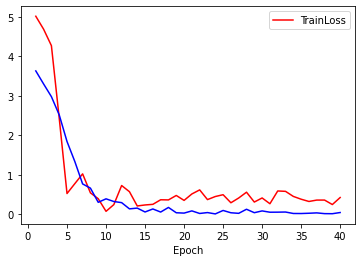

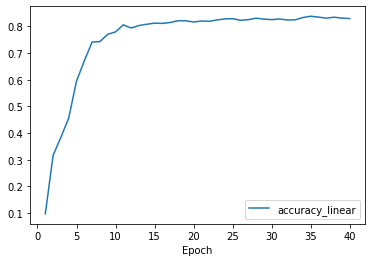

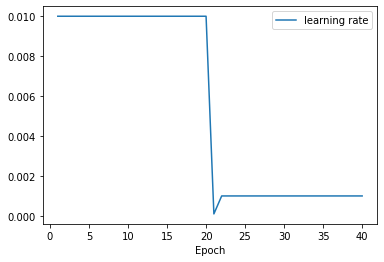

In [0]:
epoch +=1
x_epochs = np.linspace(1,epoch,epoch)

plt.plot(x_epochs, val_losses, '-', color='red')
plt.xlabel("Epoch")
plt.legend(['ValLoss'])
plt.plot(x_epochs, train_losses, '-', color='blue')
plt.xlabel("Epoch")
plt.legend(['TrainLoss'])

plt.show()

plt.plot(x_epochs, val_accs, '-')
plt.xlabel("Epoch")
plt.legend(['accuracy_linear'])
plt.show()
plt.plot(x_epochs, lrs, '-')
plt.xlabel("Epoch")
plt.legend(['learning rate'])


# **Validation**

In [0]:
alexNet = best_model
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
alexNet.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = alexNet(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 49/49 [00:05<00:00,  8.53it/s]

Validation Accuracy: 0.8322017458777885


# **Test**

In [0]:
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
alexNet.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = alexNet(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 46/46 [00:09<00:00,  4.71it/s]

Test Accuracy: 0.7227791220186658
